# JCOM Click Bandit Model for Emails
- A Bandit style model
- Based on historical observations, we compute opens and clicks of each treatment
- We use an NIG Bandit formulation
- Implement (user, date) hash based seed


In [ ]:
!pip install keyring keyrings.google-artifactregistry-auth
!pip install -U auxia.prediction.colab --index-url https://asia-northeast1-python.pkg.dev/auxia-gcp/auxia-pip/simple/ --extra-index-url https://pypi.org/simple


Looking in indexes: https://asia-northeast1-python.pkg.dev/auxia-gcp/auxia-pip/simple/, https://pypi.org/simple


In [ ]:
from google.cloud import bigquery_storage
from google.cloud import bigquery
from google.colab import data_table
from google.api_core import exceptions
import numpy as np
import pandas as pd
import xgboost as xgb
from xgboost import core as xgb_core
import lightgbm as lgbm
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn import metrics
from sklearn.metrics import log_loss, roc_auc_score, precision_recall_curve, roc_curve, auc
import seaborn as sns
import matplotlib.pyplot as plt
import re
from typing import NamedTuple, List
import pickle
import imblearn.over_sampling
from sklearn.preprocessing import StandardScaler
import traceback
import math
import IPython.display
from IPython import get_ipython
import datetime
import operator
import collections
import copy
from IPython.core import magic
from IPython.core import magic_arguments
ipython = get_ipython()

/usr/local/lib/python3.10/dist-packages/google/api_core/_python_version_support.py:266: FutureWarning: You are using a Python version (3.10.12) which Google will stop supporting in new releases of google.api_core once it reaches its end of life (2026-10-04). Please upgrade to the latest Python version, or at least Python 3.11, to continue receiving updates for google.api_core past that date.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
import json

In [ ]:
import tensorflow as tf

In [ ]:
from auxia.prediction.colab import control_flow_magic
from auxia.prediction.colab.algorithms.stats_utils import *
from auxia.prediction.colab.algorithms.ml_utils import gen_binary_classification_reports
from matplotlib import pyplot as plt
import seaborn as sns
from google.cloud import bigquery
from google.cloud.bigquery import magics

In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 16.8 gigabytes of available RAM

Not using a high-RAM runtime


# Data Load

In [ ]:
current_user_name = !gcloud config get-value account
current_user_name = current_user_name[0].split('@')[0]
assert current_user_name
display(f'Detected user name {current_user_name}')

'Detected user name sumeet'

Last use 60 days (let's use recent but the Metaflow bandit uses 120 days)

In [ ]:
%%bigquery df --project auxia-reporting

WITH
th as
(
  SELECT user_id, treatment_id, treatment_tracking_id, treatment_sent_timestamp, arm_id, surface_id, rank
  FROM `auxia-gcp.company_1925.treatment_history_sent`
  WHERE DATE(treatment_sent_timestamp) BETWEEN DATE_SUB(CURRENT_DATE(), INTERVAL 60 DAY) AND DATE_SUB(CURRENT_DATE(), INTERVAL 1 DAY)
  AND request_source = "LIVE"
),

views as
(
  SELECT treatment_tracking_id, interaction_timestamp_micros
  FROM `auxia-gcp.company_1925.email_interactions_table`
  WHERE DATE(interaction_timestamp_micros) BETWEEN DATE_SUB(CURRENT_DATE(), INTERVAL 60 DAY) AND DATE_SUB(CURRENT_DATE(), INTERVAL 1 DAY)
  AND interaction_type = "VIEWED"
),

clicks as
(
  SELECT DISTINCT treatment_tracking_id
  FROM `auxia-gcp.company_1925.email_interactions_table`
  WHERE DATE(interaction_timestamp_micros) BETWEEN DATE_SUB(CURRENT_DATE(), INTERVAL 60 DAY) AND DATE_SUB(CURRENT_DATE(), INTERVAL 1 DAY)
  AND interaction_type = "CLICKED"
)

SELECT th.treatment_id, th.surface_id, count(distinct views.treatment_tracking_id) as n,
count(distinct clicks.treatment_tracking_id) as clicks
FROM
th
JOIN views
ON th.treatment_tracking_id = views.treatment_tracking_id
LEFT OUTER JOIN clicks
ON th.treatment_tracking_id = clicks.treatment_tracking_id
GROUP BY ALL
;

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df["ctr"] = df["clicks"]/df["n"]

In [ ]:
df["ctr"].describe()

,ctr
count,36.0
mean,0.021827
std,0.008839
min,0.007576
25%,0.015375
50%,0.021818
75%,0.026546
max,0.0401


In [ ]:
df.sort_values("ctr", ascending=False).head(10)

,treatment_id,surface_id,n,clicks,ctr
14,8496030,817,399,16,0.0401
33,8496037,817,400,16,0.04
5,8495999,817,450,17,0.037778
28,8495877,817,391,14,0.035806
16,8496082,817,400,14,0.035
30,8495992,817,410,13,0.031707
32,8496023,817,441,13,0.029478
15,8496047,817,446,13,0.029148
0,8495793,817,407,11,0.027027
4,8495978,817,379,10,0.026385


# NIG implementation
  - Update rules based on input query
  - Thompson Sampling to generate sampled rewards

In [ ]:
assert df["ctr"].max() <= 1

In [ ]:
from auxia.prediction.colab.algorithms.bandits import NormalInverseGammaClickBandit
from auxia.prediction.colab import tensorflow_model
from auxia.prediction.colab.tensorflow import tf_random

In [ ]:
click_bandit = NormalInverseGammaClickBandit(df, treatment_id_col="treatment_id", click_col="clicks", view_col="n")
click_bandit.update()

In [ ]:
std_scaling = 1
treatment_ids = tf.constant([str(t) for t in click_bandit.treatments])
mean_vector = tf.cast(tf.constant([click_bandit.get_posterior_mean(t) for t in click_bandit.treatments]), tf.float32)
stddev_vector = tf.cast(tf.constant([(x**0.5)*std_scaling if np.isfinite(x) else 0.1 for x in [click_bandit.get_posterior_variance(t) for t in click_bandit.treatments]]), tf.float32)

In [ ]:
assert tf.reduce_min(stddev_vector).numpy() > 0

In [ ]:
tf.reduce_min(stddev_vector).numpy(), tf.reduce_max(stddev_vector).numpy()

(0.0056195976, 0.010415853)

In [ ]:
pd.Series(stddev_vector.numpy()).describe()

,0
count,36.000000
mean,0.007849
std,0.001248
min,0.005620
25%,0.007013
50%,0.007777
75%,0.008578
max,0.010416


<Axes: ylabel='Density'>

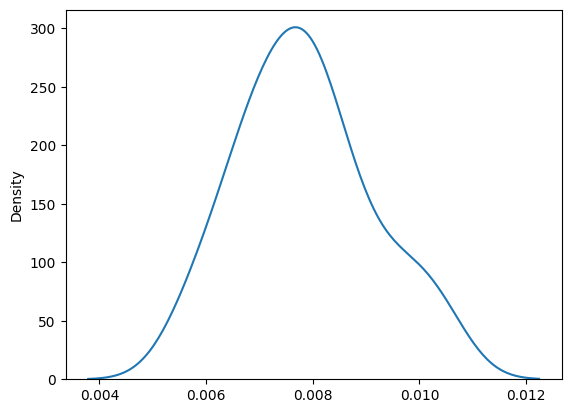

In [ ]:
sns.kdeplot(stddev_vector.numpy())

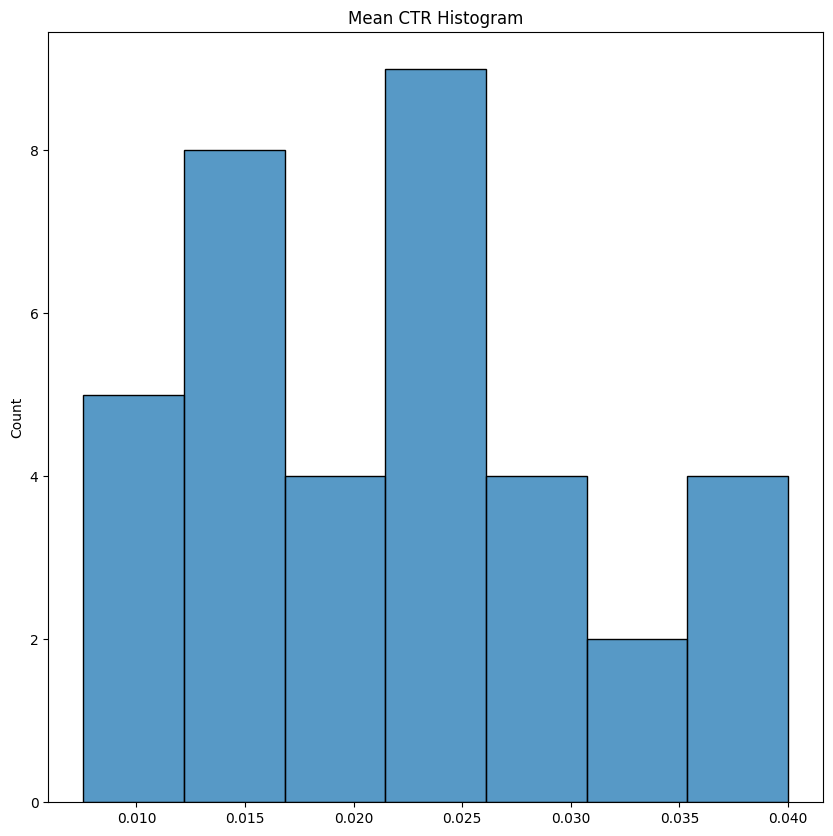

In [ ]:
plt.figure(figsize=(10,10))
sns.histplot(mean_vector.numpy())
plt.title("Mean CTR Histogram")
plt.show()

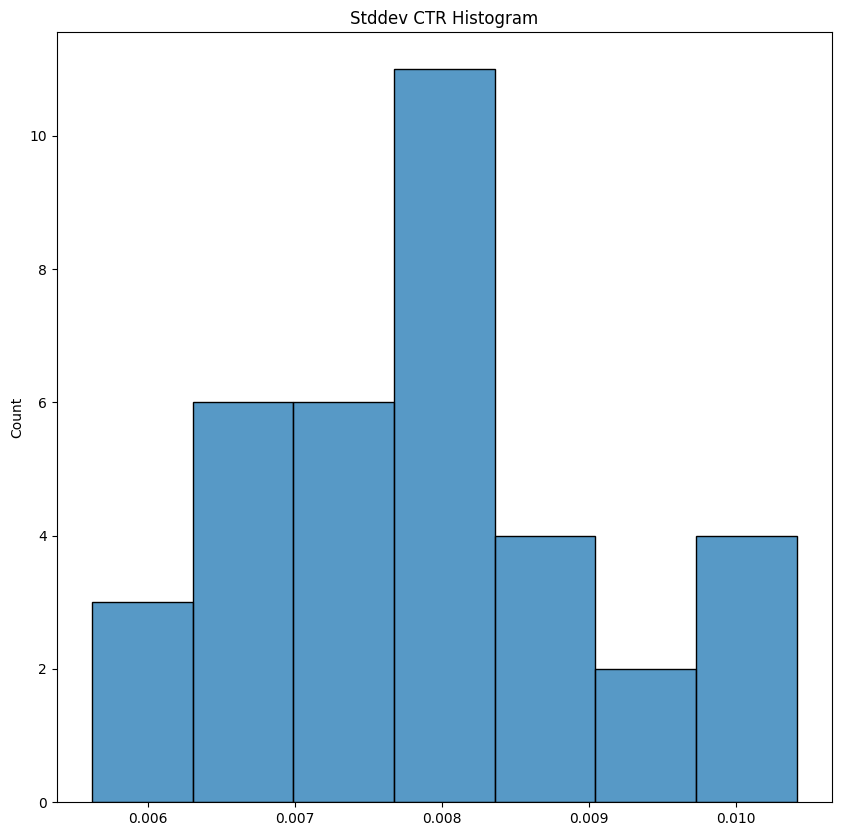

In [ ]:
plt.figure(figsize=(10,10))
sns.histplot(stddev_vector.numpy())
plt.title("Stddev CTR Histogram")
plt.show()

# Final hash maps of parameters

In [ ]:
# Create dictionary-like lookup tables for each value tensor
default_mean = 0
default_stddev = 0.05
lookup_mean = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(treatment_ids, mean_vector), default_value=default_mean)
lookup_stddev = tf.lookup.StaticHashTable(
    tf.lookup.KeyValueTensorInitializer(treatment_ids, stddev_vector), default_value=default_stddev)

# Offline Metrics
- AUC

In [ ]:
# This is going to be odd as we don't send a lot of emails so let's just get metrics on the train set
validation_date = datetime.datetime.now() - datetime.timedelta(days=14)

In [ ]:
validation_date = validation_date.strftime("%Y-%m-%d")

In [ ]:
%%substitute %DATE_DASHES%=validation_date
%%bigquery df_metrics --project auxia-reporting

WITH
th as
(
  SELECT user_id, treatment_id, treatment_tracking_id, treatment_sent_timestamp, arm_id, surface_id
  FROM `auxia-gcp.company_1925.treatment_history_sent`
  WHERE TIMESTAMP_TRUNC(treatment_sent_timestamp, DAY) > TIMESTAMP("%DATE_DASHES%")
  AND request_source = "LIVE"
),

views as
(
  SELECT treatment_tracking_id, interaction_timestamp_micros
  FROM `auxia-gcp.company_1925.email_interactions_table`
  WHERE TIMESTAMP_TRUNC(interaction_timestamp_micros, DAY) > TIMESTAMP("%DATE_DASHES%")
  AND interaction_type = "VIEWED"
),

clicks as
(
  SELECT DISTINCT treatment_tracking_id
  FROM `auxia-gcp.company_1925.email_interactions_table`
  WHERE TIMESTAMP_TRUNC(interaction_timestamp_micros, DAY) > TIMESTAMP("%DATE_DASHES%")
  AND interaction_type = "CLICKED"
)

SELECT th.*, CASE WHEN clicks.treatment_tracking_id IS NOT NULL THEN 1 ELSE 0 END AS clicked
FROM
th
JOIN views
ON th.treatment_tracking_id = views.treatment_tracking_id
LEFT OUTER JOIN clicks
ON th.treatment_tracking_id = clicks.treatment_tracking_id
;

Query is running:   0%|          |

Downloading:   0%|          |

In [ ]:
df_metrics.head()

,user_id,treatment_id,treatment_tracking_id,treatment_sent_timestamp,arm_id,surface_id,clicked
0,E7F9AD2C7478CBCF513BFBD379A1B146,8495793,8495793_817_1bb26d63-a87a-48c8-a4ba-39f12c02dcbf,2025-12-01 06:42:06.196476+00:00,3376,817,0
1,771AABB3770FAB3CEEB31057C6E285D5,8495793,8495793_817_92b67bdd-90f4-4b89-9e7e-3e0af8ed048f,2025-12-01 06:42:08.166056+00:00,3376,817,0
2,923CA3187982F586723541D82590A653,8495793,8495793_817_65dfd3cb-bc14-4ef0-92b4-1b85355db06b,2025-12-01 06:28:34.791664+00:00,3376,817,0
3,FDF5B52E9B4F32899788F7247CC7CB9E,8495793,8495793_817_f1725a28-1fe4-4362-a9ff-4fe07f99baf5,2025-12-01 06:32:47.583856+00:00,3376,817,0
4,754E75FB7FEEFFA166A3EB167EF4F588,8495793,8495793_817_9ce18be3-8dc0-49eb-b80f-abc8a117502e,2025-12-01 06:18:48.973337+00:00,3376,817,0


In [ ]:
df_metrics.clicked.value_counts()

,count
clicked,
0,19652
1,665


In [ ]:
treatment_tensor = tf.constant(df_metrics.treatment_id.astype("str"))
user_tensor = tf.constant(df_metrics.user_id.astype("str"))

In [ ]:
user_treatment_concated = treatment_tensor + ':' + user_tensor + '@' + tf.strings.as_string(tf.math.floordiv(tf.timestamp(), 86400))

In [ ]:
probabilities = tf_random.stateless_normal_batched(user_treatment_concated, 1)
probabilities = tf.cast(probabilities, tf.float32)

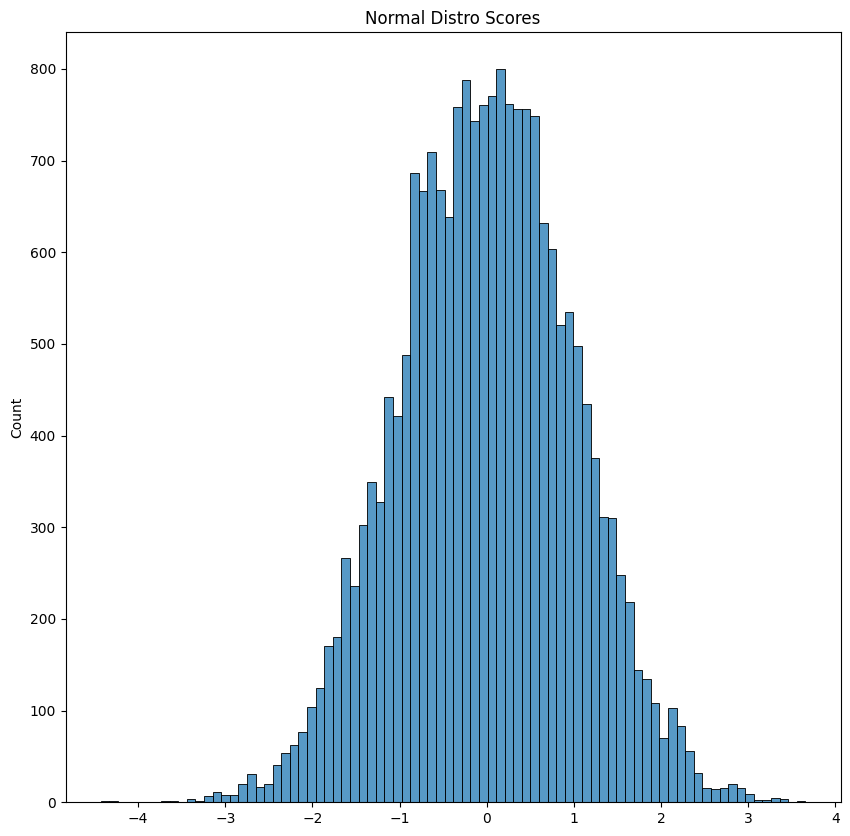

In [ ]:
plt.figure(figsize=(10,10))
sns.histplot(probabilities.numpy().flatten())
plt.title("Normal Distro Scores")
plt.show()

In [ ]:
val_scores = tf.add(tf.multiply(probabilities, tf.expand_dims(lookup_stddev.lookup(treatment_tensor),1)), tf.expand_dims(lookup_mean.lookup(treatment_tensor),1))

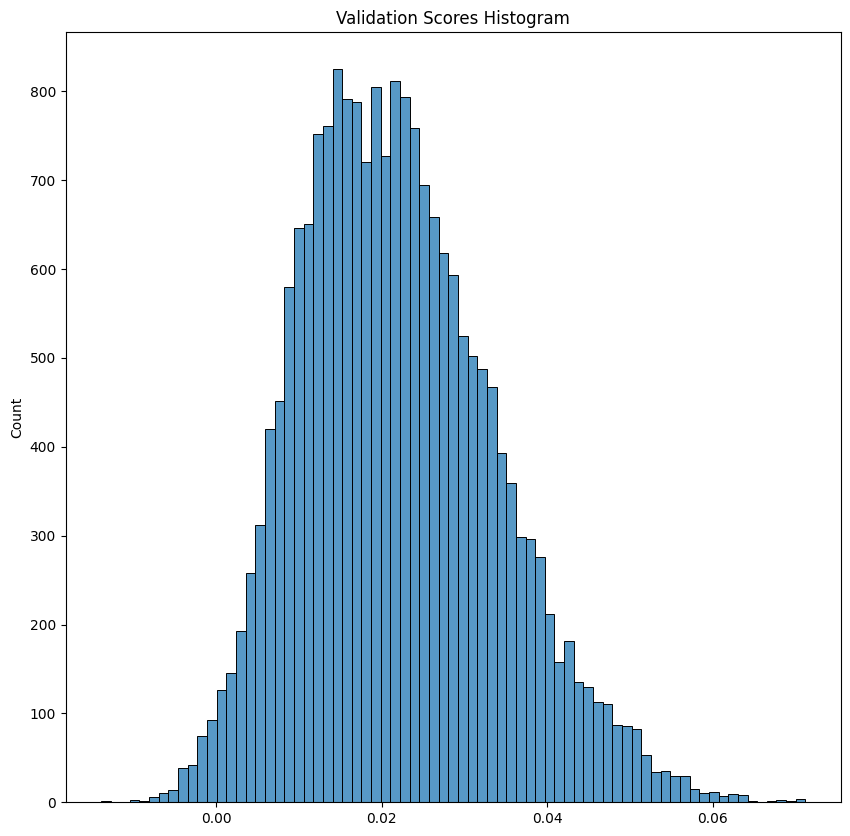

In [ ]:
plt.figure(figsize=(10,10))
sns.histplot(val_scores.numpy().flatten())
plt.title("Validation Scores Histogram")
plt.show()

AUC ROC: 0.6053
AUC PR: 0.0460


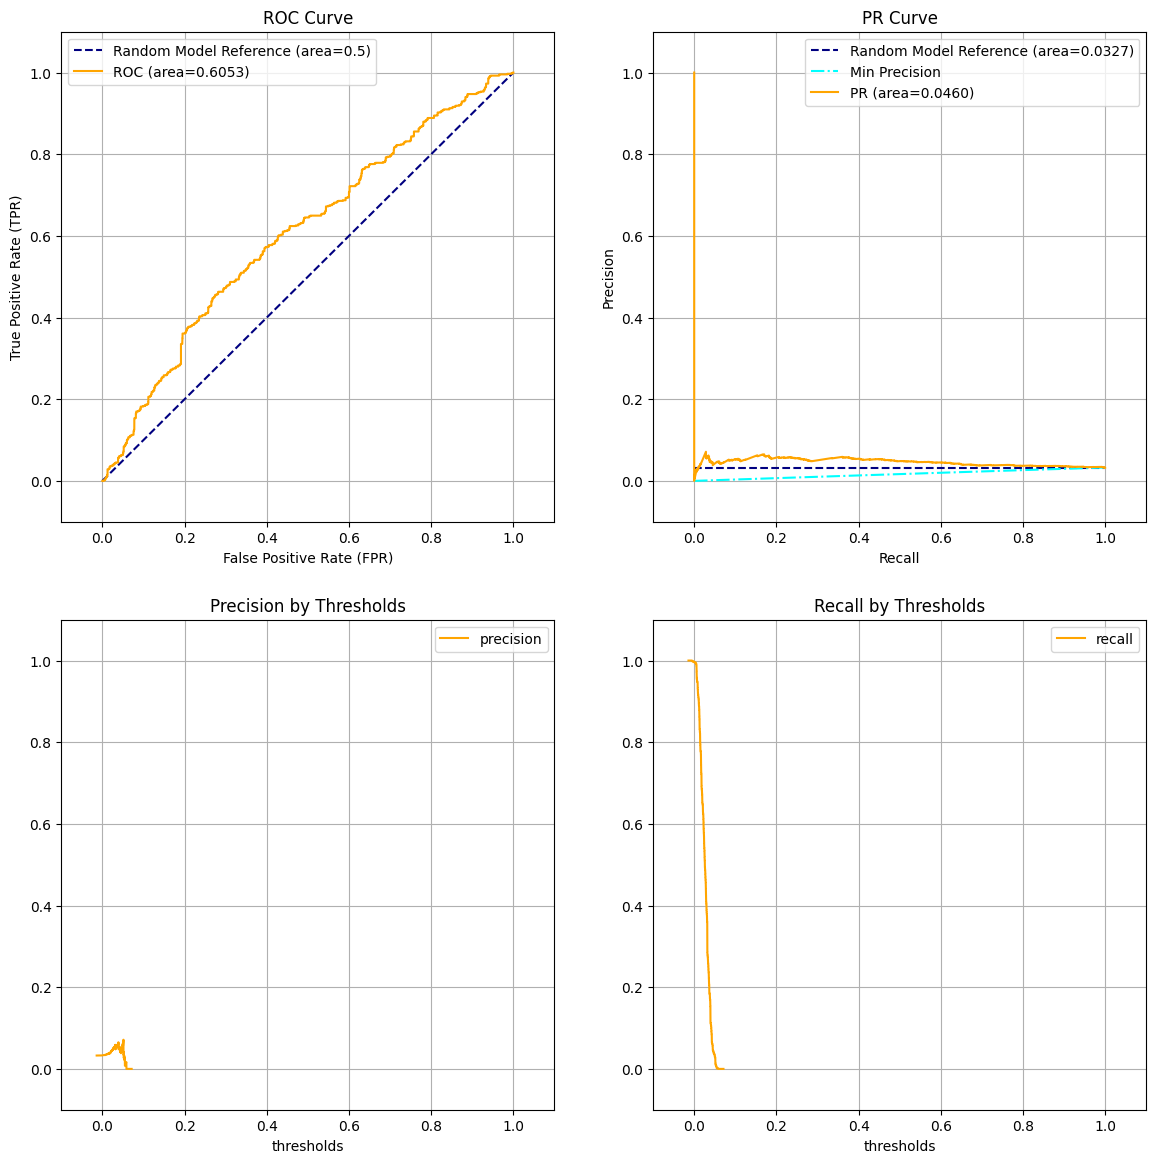

In [ ]:
_ = gen_binary_classification_reports(df_metrics.clicked.values, val_scores.numpy().flatten())

# Dev Testing

In [ ]:
treatment_df = df[["treatment_id", "surface_id"]].astype("str").drop_duplicates()

In [ ]:
treatment_df.head()

,treatment_id,surface_id
0,8495793,817
1,8495821,817
2,8495943,817
3,8495964,817
4,8495978,817


In [ ]:
class BanditClickModel(tf.Module):
  model_metadata = {
      'output': {'supported_output_types': ['PER_USER_TREATMENT_SCORE']},
      'tensorflow_contract': {
        'inputs': {
            'tensors': [
                {
                    'name': 'treatment_features',
                    'single_tensor_type': 'CATEGORICAL_STRING_TYPE',
                    'feature_source': 'TREATMENT_FEATURES',
                    'feature_names': ['treatment_id'],
                },
                {
                    'name': 'user_features',
                    'single_tensor_type': 'CATEGORICAL_STRING_TYPE',
                    'feature_source': 'USER_FEATURES',
                    'feature_names': ['user_id'],
                },
            ]
        },
    },
  }

  def __init__(self, lookup_mean, lookup_stddev):
    self.lookup_mean = lookup_mean
    self.lookup_stddev = lookup_stddev

  @tf.function(input_signature=(
      tf.TensorSpec(dtype=tf.string, shape=(None, None, 1)),
      tf.TensorSpec(dtype=tf.int64, shape=(None,)),
      tf.TensorSpec(dtype=tf.string, shape=(None, 1)),
  ))
  def __call__(self, treatment_features, treatment_count, user_features):
    # Note: prefer to parse data out of user_features before performing the
    # cartesian product to reduce unnecessary duplicate parsing overhead, and
    # reduce the size of repeated data.
    treatment_indices = tf.where(tf.sequence_mask(treatment_count))
    user_ids = tf.squeeze(user_features, axis=-1)

    # Perform cartesian product on all pre-join data.
    user_treatment_counts = treatment_count
    user_ids_cart = tf.repeat(user_ids, user_treatment_counts, axis=0)
    # The flat_values from the treatment RaggedTensor is already cartensian
    # producted.
    treatment_ids_cart = tf.gather_nd(
        tf.squeeze(treatment_features, axis=-1),
        treatment_indices)

    scoring_means = self.lookup_mean.lookup(treatment_ids_cart)
    scoring_stddevs = self.lookup_stddev.lookup(treatment_ids_cart)

    user_treatment_concated = treatment_ids_cart + ':' + user_ids_cart + '@' + tf.strings.as_string(tf.math.floordiv(tf.timestamp(), 86400))

    # Important - use tf.float64, else the 64-bit int seems to fail to cast randomly on certain platforms (arm64).
    # This could be a bug in the vector instruction support compiled into arm64 tf serving.
    probabilities = tf.reshape(tf_random.stateless_normal_batched(user_treatment_concated, 1), [-1])
    probabilities = tf.cast(probabilities, tf.float32)
    probabilities = tf.add(tf.multiply(probabilities, scoring_stddevs), scoring_means)

    return tf.scatter_nd(treatment_indices, probabilities, tf.cast(tf.shape(treatment_features)[:2], tf.int64))

In [ ]:
model, y = tensorflow_model.build_validated_model(BanditClickModel(lookup_mean, lookup_stddev), user_features=pd.DataFrame([{'user_id': str(k)} for k in range(10000)]), treatment_features=treatment_df)

======================================= test session starts ========================================
platform linux -- Python 3.10.12, pytest-8.3.4, pluggy-1.5.0
rootdir: /usr/local/lib/python3.10/dist-packages/auxia/prediction/colab/testing/test_tensorflow_model
plugins: langsmith-0.4.57, anyio-3.7.1, typeguard-4.4.1
collected 1 item

../usr/local/lib/python3.10/dist-packages/auxia/prediction/colab/testing/test_tensorflow_model/full_prediction_test.py . [100%]

======================================== 1 passed in 24.67s ========================================
Latency: mean=0:00:00.678640 50%=0:00:00.563178 95%=0:00:01.302304 99%=0:00:01.391234


In [ ]:
y.head()

,8495793,8495821,8495943,8495964,8495978,8495999,8496061,8496068,8495863,8495884,...,8495814,8495870,8495877,8495936,8495992,8496016,8496023,8496037,8496054,8496075
0,0.024177,0.020275,0.006950,0.007897,0.036642,0.040354,0.021229,0.034680,0.014286,0.012582,...,-0.000158,0.003235,0.043127,0.027875,0.034466,0.011697,0.023350,0.040502,0.026947,0.035238
1,0.031204,0.012528,0.012726,0.013685,0.030981,0.042991,0.032820,0.034327,0.020605,0.009674,...,0.017884,-0.000984,0.046406,0.031606,0.012793,0.020263,0.033931,0.063251,0.021380,0.015466
2,0.045730,0.024273,0.008295,0.009528,0.028104,0.054332,0.022108,0.023038,0.018359,0.014491,...,-0.000334,0.008344,0.031940,0.029981,0.041824,-0.002103,0.033276,0.041393,0.002393,0.006153
3,0.031250,0.027964,0.014343,0.005207,0.032191,0.032957,0.019054,0.013845,0.013695,0.017190,...,0.011751,0.007657,0.043753,0.029446,0.027462,0.012375,0.019739,0.040678,0.015183,0.020872
4,0.034170,0.025095,0.025950,0.013008,0.024011,0.037872,0.020531,0.026497,0.008443,0.010376,...,0.014902,-0.000033,0.034668,0.022382,0.030921,0.017506,0.040802,0.033967,0.024013,0.007533


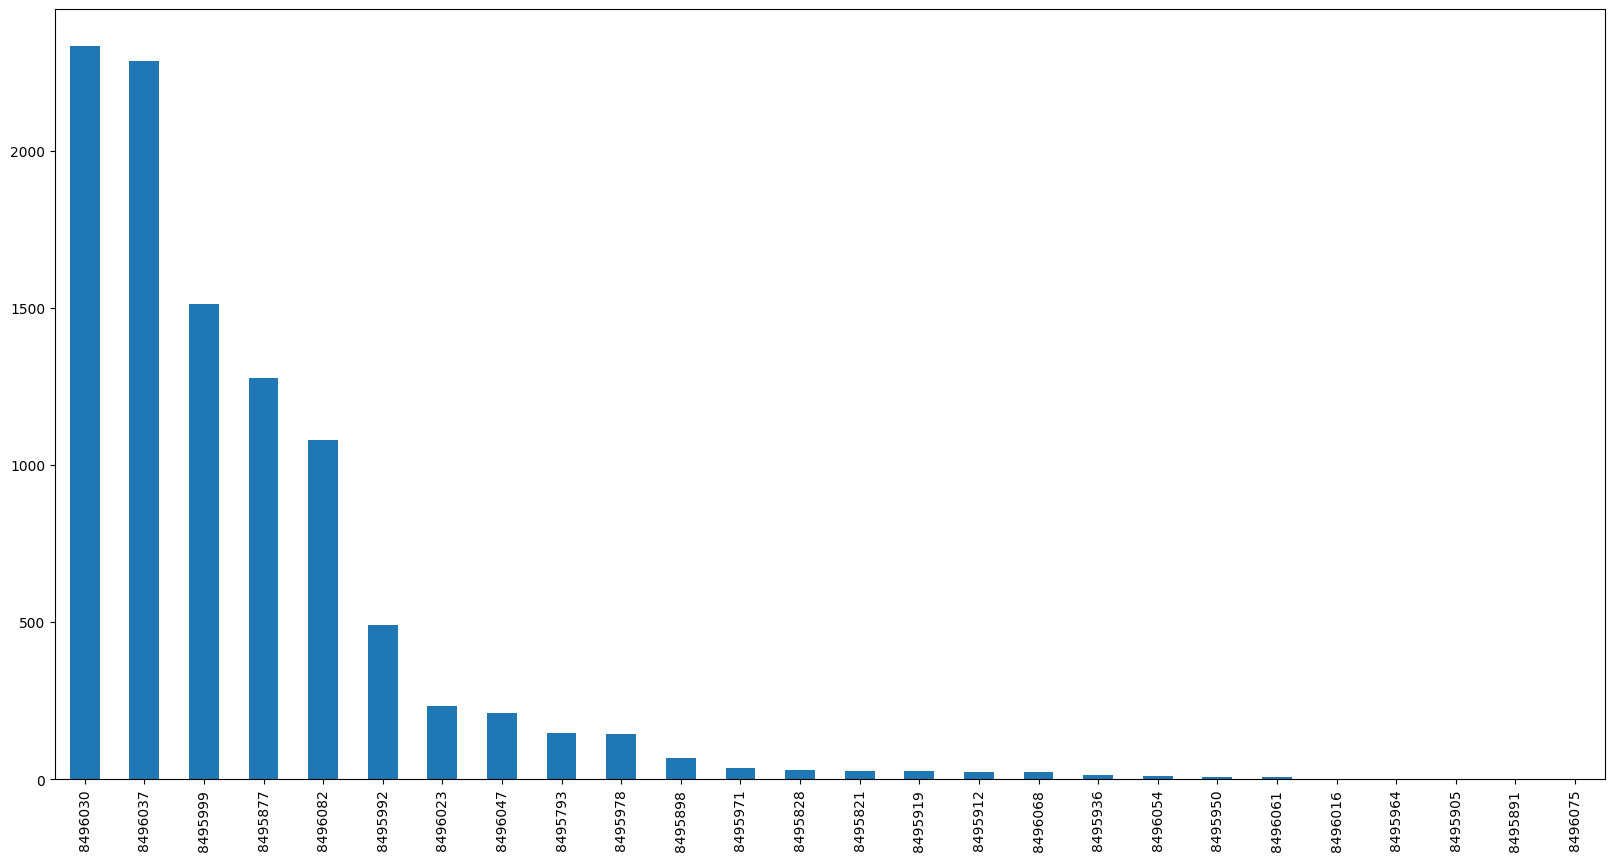

In [ ]:
y.idxmax(axis=1).value_counts().plot(kind="bar", figsize=(20,10))
plt.show()

# Prod Testing and Deployment

In [ ]:
tensorflow_model.push(
    'asia-northeast1-docker.pkg.dev/auxia-gcp/prediction-model-repo/tensorflowv2/c1925/bandit_click',
    model,
    ['hb-test.live'],
)


Pushing to asia-northeast1-docker.pkg.dev/auxia-gcp/prediction-model-repo/tensorflowv2/c1925/bandit_click:20251209223341Z.sumeet
Scheduling canary to run between 2025-12-09 22:35:41.470978 and 2025-12-09 22:45:41.470978 UTC
--------------------------------------- REMOTE BUILD OUTPUT ----------------------------------------
starting build "cdcb5920-cf68-4d0d-bf94-9af2c841e14d"

FETCHSOURCE
Fetching storage object: gs://auxia-gcp_cloudbuild/source/1765319622.677544-0cbe2996a1c64abc8647ba36d40ebd26.tgz#1765319623536912
Copying gs://auxia-gcp_cloudbuild/source/1765319622.677544-0cbe2996a1c64abc8647ba36d40ebd26.tgz#1765319623536912...
/ [1 files][ 14.8 KiB/ 14.8 KiB]                                                
Operation completed over 1 objects/14.8 KiB.
BUILD
Already have image (with digest): gcr.io/cloud-builders/docker
Sending build context to Docker daemon  90.62kB
Step 1/3 : FROM scratch
 ---> 
Step 2/3 : COPY data/ /data/
 ---> 1dab0251ecc9
Step 3/3 : LABEL auxia.canary-config="{

CalledProcessError: Command '[PosixPath('/tmp/gcrane.extracted/gcrane'), 'tag', 'asia-northeast1-docker.pkg.dev/auxia-gcp/prediction-model-repo/tensorflowv2/c1925/bandit_click:20251209223341Z.sumeet', 'hb-test.live']' returned non-zero exit status 1.

In [ ]:
tensorflow_model.push(
    'asia-northeast1-docker.pkg.dev/auxia-gcp/prediction-model-repo/tensorflowv2/c1925/bandit_click',
    model,
    ['jp-prod.stable'],
    metrics_project = "auxia-gcp",
    canary_percentage = 50
)


Pushing to asia-northeast1-docker.pkg.dev/auxia-gcp/prediction-model-repo/tensorflowv2/c1897/bandit_cta_click:20251209030521Z.sumeet
Scheduling canary to run between 2025-12-09 03:07:21.324541 and 2025-12-09 03:17:21.324541 UTC
--------------------------------------- REMOTE BUILD OUTPUT ----------------------------------------
starting build "53353c45-2d99-4376-8b61-982f787902f3"

FETCHSOURCE
Fetching storage object: gs://auxia-gcp_cloudbuild/source/1765249521.703927-55b6ae6274b9406cacc89a36505f91cf.tgz#1765249522455629
Copying gs://auxia-gcp_cloudbuild/source/1765249521.703927-55b6ae6274b9406cacc89a36505f91cf.tgz#1765249522455629...
/ [1 files][ 16.0 KiB/ 16.0 KiB]                                                
Operation completed over 1 objects/16.0 KiB.
BUILD
Already have image (with digest): gcr.io/cloud-builders/docker
Sending build context to Docker daemon  96.26kB
Step 1/3 : FROM scratch
 ---> 
Step 2/3 : COPY data/ /data/
 ---> 4fbec5ec38b3
Step 3/3 : LABEL auxia.canary-confi